In [23]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os, random

from modules.painting import painting
from modules.database import database as db

from keras.models import Sequential, Model
from keras import models
from keras.layers.core import (Dropout, Flatten, Dense, Activation)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import (RandomFlip, RandomRotation, Input, BatchNormalization, 
                          RandomTranslation, RandomZoom)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import ResNet50

from tensorflow import unique_with_counts

#### Control Variables

In [2]:
# setting path variables for Working Directory and folder to save and load
#   models from.
wd = os.getcwd()
WD_PATH =  os.path.abspath(wd)
PATH_TRAINING = os.path.join(WD_PATH, "model_training")

# # initializing the database object
gallery = db()

# Size of the pictures when reduced in size
PIXEL_SIZE = 224

# the proportions to split the available paintings in training
# and testing.
keep_unused = 10
prop_train = 0.8
prop_test = 0.2

# selection  of artists to use. (our ids)
# 3,4,10 = Pierre-Auguste Renoir, Francisco Goya, Paul Gauguin
artists = [3,4,10]
count_artists = len(artists)

# defining labels in a list
class_names = []
for k in artists:
    class_names.append(gallery.get_artist(k)[0][1])

In [3]:
# checking the available paintings per artist.
num_paintings = np.zeros(count_artists,np.int16)
for j in range(count_artists):
    num_paintings[j] = len(gallery.get_paintingids_from_artist(artists[j]))
print(num_paintings)
# Total number of paintings available
TOTAL_PAINTINGS = sum(num_paintings)

[336 291 311]


In [4]:
# Weights for the model:
class_temp = TOTAL_PAINTINGS / num_paintings
class_weights = {}
for i in range(count_artists):
    class_weights[i] = class_temp[i]
class_weights

{0: 2.7916666666666665, 1: 3.223367697594502, 2: 3.0160771704180065}

In [5]:
# coding the sizes needed as collection arrays for the input data
SIZE_P_TRAINING = 0
training_size_paintings = num_paintings.copy()
SIZE_P_TESTING = 0
testing_size_paintings = num_paintings.copy()
for i in range(count_artists):
    train_count = int((num_paintings[i] - keep_unused)  * prop_train)
    test_count = int((num_paintings[i] - keep_unused)  * prop_test)
    # print(sum((train_count,test_count,10)),training_size_paintings[i])
    SIZE_P_TRAINING += train_count
    SIZE_P_TESTING += test_count
    training_size_paintings[i] = train_count
    testing_size_paintings[i] = test_count
print("total train paintings:", SIZE_P_TRAINING)
print("total test paintings:", SIZE_P_TESTING)

total train paintings: 724
total test paintings: 181


#### Loading data from DB

In [6]:
## creating arrays to hold the pictures taken from the DB
training_images = np.zeros((SIZE_P_TRAINING,PIXEL_SIZE,PIXEL_SIZE,3))
index_training = 0
skip_count_training = 0
testing_images = np.zeros((SIZE_P_TESTING,PIXEL_SIZE,PIXEL_SIZE,3))
index_testing = 0
skip_count_testing = 0
# creating the arrays to hold labels. In this case they are the artist ids.
training_labels = np.array([0]*SIZE_P_TRAINING,dtype=int)
testing_labels = np.array([0]*SIZE_P_TESTING,dtype=int)
unused_paintings = np.array(
    [0]*(TOTAL_PAINTINGS-SIZE_P_TESTING-SIZE_P_TRAINING)
    ,dtype=int)
# checking if the numbers add up.
print(training_images.shape)
print(testing_images.shape)
print(training_labels.shape)
print(testing_labels.shape)
print(unused_paintings.shape)

(724, 224, 224, 3)
(181, 224, 224, 3)
(724,)
(181,)
(33,)


Loop over the artists and adding randomized pictures of them to the <br>
training and testing sets. There are also ids collected, which are unused, <br>
so that they can be used as "new, unseen" input for the model.

In [7]:
# filling the arrays with picture arrays. They will be resized according
# to the pixel_size value
unused_index = 0
for i in range(count_artists):
    # loading all ids from the artist
    ids = gallery.get_paintingids_from_artist(artists[i])
    # shuffle the ids to get random order for selection
    random.seed(1983)
    random.shuffle(ids)
    
    # getting the numbers for the current artist:
    _str = training_size_paintings[i]
    _ste = testing_size_paintings[i]
    # slicing the ids for training and testing of artist with id i+1
    ids_training = ids[ : _str]
    ids_testing = ids[_str : _str + _ste]
    ids_unused = ids[ _str + _ste : ]
    
    # collecting the ids of the unused paintings
    for l, f in zip(range(unused_index,unused_index+len(ids_unused))
                    , ids_unused):
        unused_paintings[l] = f[0]
    unused_index += len(ids_unused)
    
    # retrieving the paintings from the db, resizing them and collecting
    # them in the training_images array while also filling the labels
    for k in ids_training:
        temp_p = painting("local DB", id=k[0])
        temp_p_res = cv.resize(temp_p.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
        if temp_p_res.shape == (PIXEL_SIZE,PIXEL_SIZE,3):
            training_images[index_training] = temp_p_res
            training_labels[index_training] = i
            index_training += 1
        else:
            skip_count_training += 1
            
    # retrieving the paintings from the db, resizing them and collecting
    # them in the testing_images array while also filling the labels
    for j in ids_testing:
        temp_p = painting("local DB", id=j[0])
        temp_p_res = cv.resize(temp_p.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
        if temp_p_res.shape == (PIXEL_SIZE,PIXEL_SIZE,3):
            testing_images[index_testing] = temp_p_res
            testing_labels[index_testing] = i
            # testing_labels[index_testing] = [temp_p.artist_id-1,]
            index_testing += 1
        else:
            skip_count_testing += 1

# ## dropping the last few array positions of testing images, which where 
# ## not filled.
testing_images = testing_images[:index_testing,:,:,:]
testing_labels = testing_labels[:index_testing]
# ## dropping the last few array positions of training images, which where 
# ## not filled.
training_images = training_images[:index_training,:,:,:]
training_labels = training_labels[:index_training]

# # the pixels on an image are rescaled from 0-255 to 0-1 
training_images, testing_images = training_images/255, testing_images/255


0


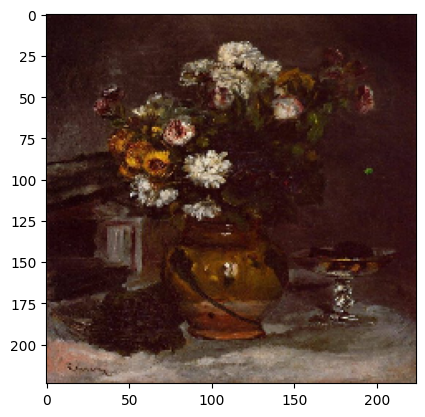

In [8]:
x = 92
img = training_images[x]
print(training_labels[x])
imgplot = plt.imshow(img)
plt.show()

In [9]:
# shuffeling all input data.
index_testing = list(range(testing_images.shape[0]))
index_training = list(range(training_images.shape[0]))
random.seed(1983)
random.shuffle(index_testing)
testing_images_shuffled = testing_images.copy()
testing_labels_shuffled = testing_labels.copy()
for i,j in zip(index_testing, range(testing_images.shape[0])):
    testing_images_shuffled[i] = testing_images[j]
    testing_labels_shuffled[i] = testing_labels[j]

random.shuffle(index_training)
training_images_shuffled = training_images.copy()
training_labels_shuffled = training_labels.copy()
for i,j in zip(index_training, range(training_images.shape[0])):
    training_images_shuffled[i] = training_images[j]
    training_labels_shuffled[i] = training_labels[j]

2


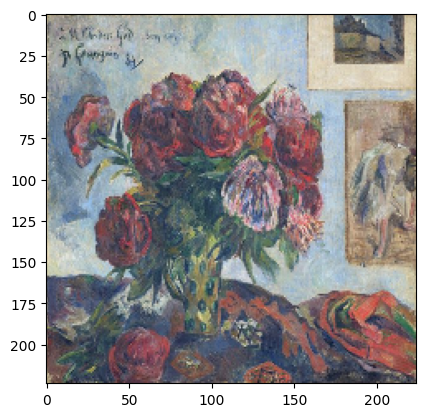

In [13]:
x = 53
img = training_images_shuffled[x]
print(training_labels_shuffled[x])
imgplot = plt.imshow(img)
plt.show()

#### Checking data shapes

In [14]:
print(training_images.shape)
print(testing_images.shape)
print(training_labels.shape)
print(testing_labels.shape)
print(type(training_labels[185:200]))
print(unused_paintings.shape)

(653, 224, 224, 3)
(160, 224, 224, 3)
(653,)
(160,)
<class 'numpy.ndarray'>
(33,)


#### Checking data counts

In [15]:
y_tl, idx_tl, count_tl = unique_with_counts(training_labels)
y_testl, idx_testl, count_testl = unique_with_counts(testing_labels)
y_unused, idx_unused, count_unused = unique_with_counts(unused_paintings)


In [16]:
print(y_tl, count_tl)
print(y_testl, count_testl)
print(unique_with_counts(count_unused)[2])


tf.Tensor([0 1 2], shape=(3,), dtype=int32) tf.Tensor([260 153 240], shape=(3,), dtype=int32)
tf.Tensor([0 1 2], shape=(3,), dtype=int32) tf.Tensor([65 35 60], shape=(3,), dtype=int32)
tf.Tensor([33], shape=(1,), dtype=int32)


***
## Modelling part
####  creating the model


In [19]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False
                      , input_shape=(PIXEL_SIZE,PIXEL_SIZE,3))

for layer in base_model.layers:
    layer.trainable = True
base_model.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [27]:
# adding Layers for Output and reduction
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(3, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [28]:
# compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [29]:
## training the model
epochs = 10
batch_size = 16

early_stopping = EarlyStopping(patience = 20,
                               mode="auto",
                               monitor="val_loss",
                               verbose = 1, 
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')
    
history = model.fit(training_images_shuffled,
                    training_labels_shuffled,
                    validation_data = (testing_images_shuffled, testing_labels_shuffled),
                    class_weight = class_weights,
                    epochs = epochs,
                    callbacks=[reduce_lr],
                    batch_size = batch_size,
                    # callbacks = early_stopping,
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/10


c:\Users\bvondewitz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


 8/41 [====>.........................] - ETA: 2:20 - loss: 0.0000e+00 - accuracy: 0.2422

In [103]:
model.save(os.path.join(PATH_TRAINING,"IC_VGG19base_3Artists_Renoir_Goy_Gauguin.model"))

INFO:tensorflow:Assets written to: c:\Users\bvondewitz\Documents\CodeBase\GruppenProjekt\model_training\IC_VGG19base_3Artists_Renoir_Goy_Gauguin.model\assets


INFO:tensorflow:Assets written to: c:\Users\bvondewitz\Documents\CodeBase\GruppenProjekt\model_training\IC_VGG19base_3Artists_Renoir_Goy_Gauguin.model\assets


In [ ]:
model = models.load_model(os.path.join(PATH_TRAINING,"IC_VGG19base_3Artists_Renoir_Goy_Gauguin.model"))

#### check one prediction

1404
(1, 256, 256, 3)
1/1 [==============================] - 0s 137ms/step
[[0.8042 0.1958 0.    ]]
0
Prediction is Pierre-Auguste Renoir
Correct is  Pierre-Auguste Renoir


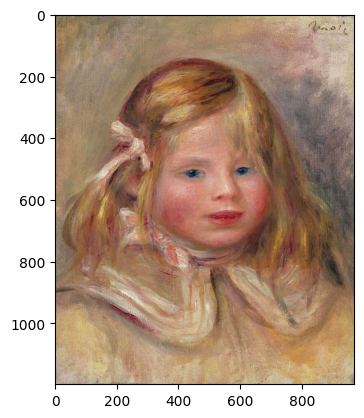

In [102]:
test_painting = painting("local DB",random.choice(unused_paintings))
print(test_painting.id)
test_ndarray = cv.resize(test_painting.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
test_ndarray = test_ndarray/255
temp_array = np.zeros((1,PIXEL_SIZE,PIXEL_SIZE,3))
print(temp_array.shape)
temp_array[0] = test_ndarray
prediction = model.predict(temp_array)
np.set_printoptions(suppress=True)
print(np.round(prediction, 4))
print(np.argmax(prediction))
index = np.argmax(prediction)
print(f"Prediction is {class_names[index]}")

art_id = gallery.get_painting(test_painting.id)[1]
print("Correct is ", gallery.get_artist(art_id)[0][1])

imgplot = plt.imshow(test_painting.ndarray)
plt.show()